# Assignment - Battle of Neighborhoods

Let's import some libraries

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import lxml

In [2]:
import folium

Getting the page

In [3]:
page_address = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(page_address)
print(r.status_code)
soup = bs(r.text)
#print(soup.prettify())

200


Using the Chrome, analise the page at rest

In [4]:
table = soup.find('table', class_='wikitable')

scraping the table...

In [5]:
df = pd.DataFrame(columns = ['PostalCode', 'Borough', 'Neighborhood'])
#print(table.find_all("tr"))
for row in table.find_all("tr"):
    #print('iteration')
    cells = row.findAll('td')
    if (len(cells) == 3):
        a = cells[2].text.rstrip('\n')
        if ('Not assigned' in a):
            if (not('Not assigned' in cells[1])):
                #print('append 2')
                df = df.append(pd.Series({'PostalCode':cells[0].text, 'Borough':cells[1].text, 'Neighborhood':cells[1].text + ', '}), ignore_index=True)
        else:
            a=a+', '
            #print('append 3')
            df = df.append(pd.Series({'PostalCode':cells[0].text, 'Borough':cells[1].text, 'Neighborhood':a}), ignore_index=True)
    

assembling all neighborhoods within the same Postal Code

In [6]:
dres = df.groupby(['PostalCode', 'Borough']).sum()

In [7]:
#dres.index

stripping trailing spaces and commas

In [8]:
dres['Neighborhood'] = dres['Neighborhood'].apply(lambda x: x.rstrip(', '))
#dres

The next two cells to do with the geocoder interface were completely commented out. The geocoder interface now requires paying account, and I would have to publish the key for review. Instead, the pre-locaded .csv will be used. The code is left in case someone is interested

In [9]:
#dres.reset_index(inplace=True)
#dres

In [10]:
#import geocoder 
#d = dres
#def locate(x):
#    y = x['PostalCode']
#    print(f'locating {y}')
#    lat_lng_coords = None
#    while(lat_lng_coords is None):
#        g = geocoder.google(x['PostalCode'] + ', Toronto, Ontario')
#        print(g)
#        lat_lng_coords = g.latlng
#        #print('tried')
#    x['Lattitude'] = lat_lng_coords[0]
#    x['Longitude'] = lat_lng_coords[1]
#    return x
#
#d = d.apply(locate, axis=1)
#d


In [11]:
url = 'https://cocl.us/Geospatial_data'
locs = pd.read_csv(url)
#locs.set_index(['Postal Code'], inplace=True)

In [12]:
#dres.set_index(['PostalCode'], inplace=True)
dres.reset_index(inplace=True)

In [13]:
locs


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [14]:
res = pd.merge(left=dres,right=locs, left_on='PostalCode', right_on='Postal Code')
res.drop(columns='Postal Code', inplace=True)
res

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


# Clustering neighborhoods

First, let's assemble the dataset. For each neighborhood, we went to have a number of venues of each type. 
We will, however, save the primary responces in case we need to work with individual venues

### Setting up the credentials

In [15]:
import json
CID = '5ROIXCJTA4EM00Y1OVYBMMMHSXF2VUF1TW0SWVKROK0YHI2M' # your Foursquare ID
SEC = 'G2U1V03CGF5JF1L5CV0THPXRWR1LEPYUMIBQGJHZVUS04ODA' # your Foursquare Secret
VER = '20180604'
LIMIT = 30
#RAD = 500 #Radius
print('Your credentails:')
print('CLIENT_ID: ' + CID)
print('CLIENT_SECRET:' + SEC)

Your credentails:
CLIENT_ID: 5ROIXCJTA4EM00Y1OVYBMMMHSXF2VUF1TW0SWVKROK0YHI2M
CLIENT_SECRET:G2U1V03CGF5JF1L5CV0THPXRWR1LEPYUMIBQGJHZVUS04ODA


## Create custom radius for each Postal Code

Recommended radius of 500 meters seem to be too be too small for some areas, and too big for others. Instead, we will use half of minimal distance to another Post Code centre. 


For any postcode, find half of the minimal distance to location associated another postcode. We will use it as a radius, which can be from about 75m to about 1800m

In [16]:
import geopy.distance as dis
l = res.shape[0]
la = res['Latitude']
lo = res['Longitude']
dd = np.empty([l,l])
mindist = 40000 # definitely bigger than any distnce in Canada in m
for i in range(0,l):
    for j in range(i+1, l):
        d = dis.distance((la[i], lo[i]), (la[j], lo[j])).m
        if (d<mindist):
            mindist=d
        dd[i,j] = d
        dd[j,i] = d
for i in range(0,l)        :
    dd[i,i] = 1e+10


In [17]:
dismin = np.amin(dd, axis = 1)
dismin = dismin/2

## Placing Neighborhoods on a Map

In [18]:
tlat = 43.741667
tlong = -79.373333
mapt = folium.Map(location=[tlat, tlong], zoom_start=10)

In [19]:
for i in range(res.shape[0]):
    text = res['PostalCode'][i] + ': ' + res['Neighborhood'][i]
    label = folium.Popup(text, parse_html=True)
    folium.Circle(
        [res['Latitude'][i], res['Longitude'][i]],
        radius=dismin[i],
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapt) 

In [20]:
mapt


## Getting information from Foursquare

For each Postal Code, record the number of venues of each category. 

In order not to run out of account limits we willl implement caching of responses. That would give us:
1. ability to re-run that piece  of code again and again
2. ability to conduct finer-graned processing later

In [21]:
def get_explore(X):
    cats = {}
    try:
        f = open(X['PostalCode']+'.json')
        results = json.load(f)
        f.close
        # Do something with the file
    except IOError:
        print(X['PostalCode']+'.json is not there')
        lat = X['Latitude']
        long = X['Longitude']
        rad = dismin[X.name]
        url1 = f'https://api.foursquare.com/v2/venues/explore?client_id={CID}&client_secret={SEC}&ll={lat},{long}&radius={rad}&v={VER}&limit=50'
        results = requests.get(url1).json()
        with open(X['PostalCode']+'.json', 'w') as outfile:
            json.dump(results, outfile)
    for v in results['response']['groups'][0]['items']:
        #print(X['PostalCode']+ ' has ' + v['venue']['name'])
        for c in v['venue']['categories']:
            #print(v['venue']['name'] + ' has category ' + c['name'])
            cn = c['name']
            if cn in cats:
                cats[cn] = cats[cn]+1
            else:
                cats[cn] = 1
    return(cats)

In [22]:

rescat = res.apply(get_explore, axis = 1, result_type = 'expand')
rescat.fillna(0, inplace=True)
rescat

,Zoo Exhibit,Spa,Fast Food Restaurant,Caribbean Restaurant,Liquor Store,Paper / Office Supplies Store,Pizza Place,Coffee Shop,Martial Arts Dojo,Gym,...,River,Supplement Shop,Buffet,Transportation Service,Empanada Restaurant,Golf Driving Range,Racecourse,Casino,Theme Park,Auto Garage
0,20.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,1.0,1.0,0.0,0.0,4.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare numpy array for KMeans. 
As we want to use cosine similarity, we need to square-normalise all rows

In [23]:
ca = rescat.to_numpy(dtype=float)

In [24]:
casq = np.square(ca)
vec = np.sqrt(np.sum(casq, axis = 1))
print(vec.shape)
#vec = np.array((lambda x:(1 if x==0 else 1)) for xi in vec)
#print(casq)
#input = np.divide(casq, vec)
input = ca/vec[:,None]
from numpy import inf
input[input == -inf] = 0
input = np.nan_to_num(input)
input

(103,)


/home/alex1/projects/Coursera_Capstone/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


array([[0.97128586, 0.04856429, 0.14569288, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.28867513, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.15617376, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.13483997, ..., 0.13483997, 0.13483997,
        0.13483997]])

## Deciding on a number of clusters

Build a list of sum of squared distance (SSE) between data points for number of clusters between 2 and 8

In [25]:
from sklearn.cluster import KMeans
sse = []
klist = range(2,9)
for k in klist:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(input)
    sse.append(km.inertia_)
#clus = km.fit_predict(input)

 Plot sse against k

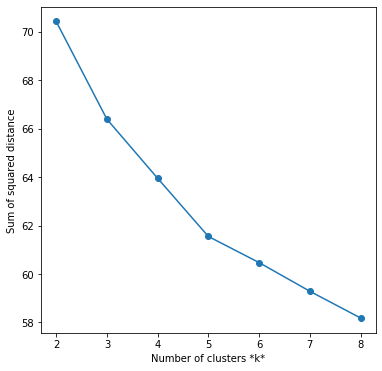

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot(klist, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Observe the elbow at the number of clusters = 55

In [27]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(input)
clus = km.fit_predict(input)



In [28]:
clus


array([1, 4, 0, 4, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 3, 1, 4, 1,
       1, 3, 0, 4, 3, 3, 3, 3, 3, 4, 1, 0, 3, 0, 4, 2, 3, 3, 3, 2, 2, 2,
       4, 4, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 4, 2,
       2, 2, 4, 2, 2, 3, 0, 3, 4, 4, 4, 2, 2, 4, 4, 3, 2, 2, 2, 2, 3, 1,
       4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 1, 0, 0, 0, 3], dtype=int32)

Define descriptions of clusters as first 4 most common categories

In [29]:
rescat['Cluster'] = clus

In [30]:
clusname = []
for c in range(num_clusters):
    t=rescat.loc[rescat['Cluster']==c].copy()
    t.drop(['Cluster'], axis=1, inplace=True)
    t_res = t.sum(axis = 0)
    t_res.sort_values(ascending=False, inplace=True)
    cdesc = t_res.index[0] + ', ' + t_res.index[1] + ', ' + t_res.index[2] + ', ' + t_res.index[3] 
    clusname.append(cdesc)

Build a map

In [31]:
import matplotlib.cm as cm
import matplotlib.colors as colors

ckeys = ['red', 'blue', 'green', 'chocolate', 'magenta', 'yellow', 'grey', 'darkorange', 'aquamarine', 'darkviolet']

In [32]:
tlat = 43.741667
tlong = -79.373333
mapt = folium.Map(location=[tlat, tlong], zoom_start=10)

In [33]:
for i in range(res.shape[0]):
    #text = res['PostalCode'][i] + ': ' + res['Neighborhood'][i]
    text = clusname[clus[i]]
    label = folium.Popup(text, parse_html=True)
    c= ckeys[clus[i]]
    folium.Circle(
        [res['Latitude'][i], res['Longitude'][i]],
        radius=dismin[i],
        popup=label,
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.5,
        parse_html=False).add_to(mapt) 

In [34]:
mapt